In [1]:
import sklearn
import os
import re
import csv
import pandas as pd
import numpy as mp
import seaborn as sns
import matplotlib.pyplot as plt
import neattext.functions as nfx
from bs4 import BeautifulSoup
import torch
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.6.0+cu124
12.4
True


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8

In [ ]:
# Modeli yükleme
#model = DistilBertForSequenceClassification.from_pretrained('./modelb1')
model = BertForSequenceClassification.from_pretrained('./modelb')
#model = RobertaForSequenceClassification.from_pretrained('./modelr1')
# Tokenizer'ı yükleme
#mytokenizer = DistilBertTokenizer.from_pretrained('./tokenb1')
mytokenizer = BertTokenizer.from_pretrained('./tokenb')
#mytokenizer = RobertaTokenizer.from_pretrained('./tokenr1')

In [6]:
model = model.to(device) # Önemli

In [7]:
#mytokenizer1 = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [8]:
import pandas as pd

# Excel dosyasını oku
df1 = pd.read_excel('testdataset.xlsx')  # Dosya adını kendi dosyana göre değiştir

In [9]:
#df1['Emotion'] = df1['Emotion'].replace('joy', 'happiness')

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

# Gerçek label sütununu listelere çeviriyoruz (multi-label formatta gibi görünmesi için)
df1['labels'] = df1['emotion'].apply(lambda x: [x])

mlb = MultiLabelBinarizer(classes=['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral'])
y_test1 = mlb.fit_transform(df1['labels'])

In [11]:
df1

,text,emotion,labels
0,"I remember her sinking beneath the waters, and...",sadness,[sadness]
1,"I think I will miss you forever, like the star...",sadness,[sadness]
2,"I really loved her, but she left.",sadness,[sadness]
3,This is both incredible and terrifying…. Just ...,fear,[fear]
4,When he says tissue damage he really means bra...,anger,[anger]
...,...,...,...
295,Amazing work from Neuralink!,happiness,[happiness]
296,This would be terrifying if abused… And as wit...,fear,[fear]
297,This is impressive but scary. I don't think I ...,fear,[fear]
298,One of the most dangerous things I've ever hea...,fear,[fear]


In [12]:
#df1 = df1[df1['Emotion'] != 'neutral']

<Axes: xlabel='emotion', ylabel='count'>

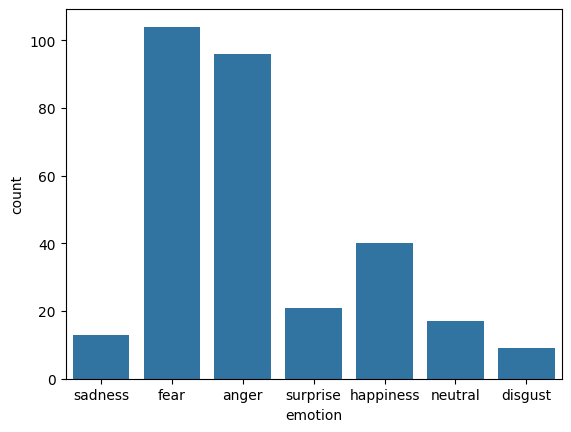

In [13]:
sns.countplot(x='emotion',data=df1)

In [14]:
inputs1 = mytokenizer(df1['text'].tolist(), padding=True, truncation=True, max_length=MAX_LEN, return_tensors='pt')

In [15]:
class EmotionDataset(Dataset):
    def __init__(self, texts, label_vectors, tokenizer, max_len):
        self.texts = texts
        self.label_vectors = label_vectors
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        labels = torch.tensor(self.label_vectors[item], dtype=torch.float)

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels
        }

In [16]:
test_dataset1 = EmotionDataset(df1['text'].tolist(), y_test1, mytokenizer, max_len=MAX_LEN)
test_dataloader1 = DataLoader(test_dataset1, batch_size=VALID_BATCH_SIZE, sampler=SequentialSampler(test_dataset1))

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model_single_prediction(model, dataloader, device, mlb):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", ncols=100):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()  # Gerçek one-hot vektörler
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.sigmoid(logits)

            # Olasılıkları ayarla
            for i in range(probs.size(0)):
                # class indexlerine göre düzeltmeler
                for j, class_name in enumerate(mlb.classes):
                    if class_name == "neutral":
                        probs[i][j] *= 0.5
                    elif class_name == "happiness":
                        probs[i][j] *= 0.7

            preds = torch.argmax(probs, dim=1).cpu().numpy()  # En yüksek olasılık
            true = [label.argmax() for label in labels]  # Gerçek label: one-hot içindeki 1 olan indeks

            y_true.extend(true)
            y_pred.extend(preds)

    # Skorları hesapla
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print("\nEvaluation Results:")
    print(f"Accuracy : {acc * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall   : {recall * 100:.2f}%")
    print(f"F1 Score : {f1 * 100:.2f}%")

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=mlb.classes))

    matrix = confusion_matrix(y_true, y_pred)
    print("Class Confusion Matrix\n", matrix)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix (Custom Decision Tree)")
    plt.show()

    return

Evaluating: 100%|███████████████████████████████████████████████████| 38/38 [00:02<00:00, 13.67it/s]



Evaluation Results:
Accuracy : 82.67%
Precision: 84.27%
Recall   : 82.67%
F1 Score : 82.94%

 Classification Report:
              precision    recall  f1-score   support

       anger       0.88      0.80      0.84        96
     disgust       0.86      0.67      0.75         9
        fear       0.94      0.85      0.89       104
   happiness       0.73      0.95      0.83        40
     sadness       0.63      0.92      0.75        13
    surprise       0.79      0.71      0.75        21
     neutral       0.57      0.71      0.63        17

    accuracy                           0.83       300
   macro avg       0.77      0.80      0.78       300
weighted avg       0.84      0.83      0.83       300

Class Confusion Matrix
 [[77  0  3 10  2  1  3]
 [ 0  6  0  0  1  0  2]
 [ 5  1 88  2  3  2  3]
 [ 0  0  0 38  1  0  1]
 [ 1  0  0  0 12  0  0]
 [ 4  0  2  0  0 15  0]
 [ 1  0  1  2  0  1 12]]


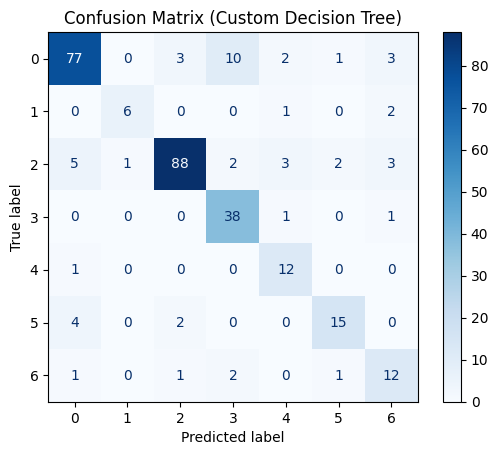

In [18]:
evaluate_model_single_prediction(model, test_dataloader1, device, mlb)